# GPT-1 모델
https://actionpower.medium.com/%EC%95%A1%EC%85%98%ED%8C%8C%EC%9B%8Clab-gpt-1-generative-pre-training-%EC%95%8C%EC%95%84%EB%B3%B4%EA%B8%B0-f63f18efa625

## 1. Encoder block 제거 
   decoder만을 사용해 이전 토큰들을 기반으로 순차적으로 다음 토큰을 예측합니다. 즉, 모델이 문맥을 생성하는 데에만 집중합니다
   gpt-1은 deocder 부분만 필요로 함으로 기존 transformer 그림에서 encoder 부분을 제거

## 2. positional encoding layer
   기존 transformer에서는 positional embedding을 cos,sin을 사용하여 구했지만 gpt-1에서는 cos,sin으로 구하지 않고 위치 인코딩을 네트워크가 학습할 수 있도록 임베딩 레이어의 일부로 포함시킴

## 3. deocdr masked multi-head Self-attention
   
   이 부분은 encoder의 참조 없이 decoder 스스로 attention 하는 부분임으로 남겨 놓음
   이미 생성된 문장들만 참고하기 위해 masking 사용
  
## 4. cross attention 제거 
   gpt-1 model은 encoder 부분이 필요 없어짐으로 decoder가 encoder로 부터 받는 key,value값을 전달하는 cross attention 제거
   


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout
from tensorflow.keras import activations


## 데이터 수집하기

In [5]:
transformer_file_path = './data.csv'
transformer_data = pd.read_csv('./data/data.csv', encoding ='cp949')

In [6]:
transformer_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [7]:
transformer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [8]:
transformer_data['length'] = transformer_data['Q'].apply(lambda x: len(x.split()))  # Q열의 문장 길이

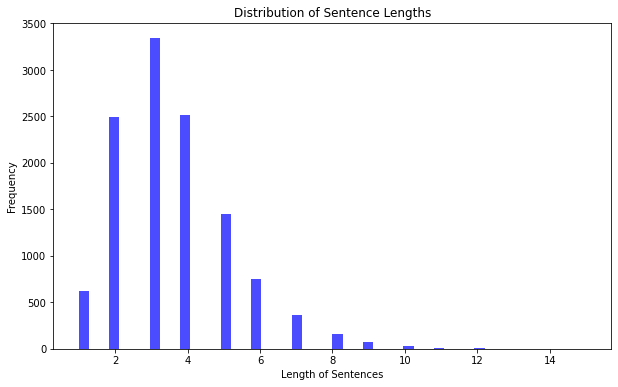

In [9]:
# 길이 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(transformer_data['length'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Length of Sentences')
plt.ylabel('Frequency')
plt.show()


In [10]:
transformer_data['length'] = transformer_data['A'].apply(lambda x: len(x.split()))  # A열의 문장 길이

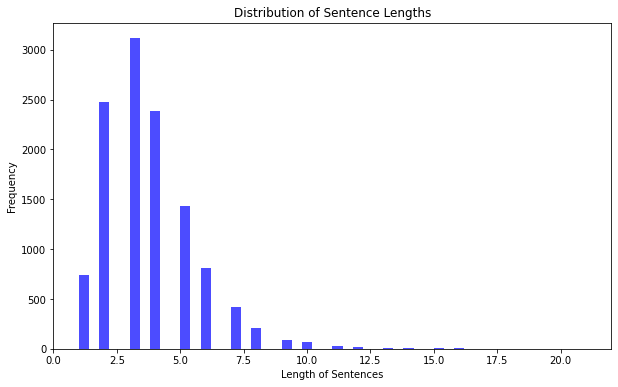

In [11]:
# 길이 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(transformer_data['length'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Length of Sentences')
plt.ylabel('Frequency')
plt.show()


In [12]:
num_samples = transformer_data.shape[0]  # 또는 len(transformer_data)
print(f'Number of samples: {num_samples}')

Number of samples: 11823


## 데이터 전처리 하기

##  SubwordTextEncoder 사용하기

In [13]:
MAX_SAMPLES = 11823

In [14]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    
    # 구두점과의 거리를 만듭니다 (예: "I am a student." -> "I am a student .")
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # 공백이 두 개 이상일 때 하나로 치환
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 한글과 영어, 구두점(. , ? !)을 제외한 모든 문자를 공백으로 대체
    sentence = re.sub(r'[^a-zA-Z0-9.,?!가-힣]', ' ', sentence)
    
    sentence = sentence.strip()
    return sentence


In [15]:
questions = transformer_data['Q'].apply(preprocess_sentence).tolist()
answers = transformer_data['A'].apply(preprocess_sentence).tolist()

In [16]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


In [17]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [18]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [19]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5758, 610, 2487, 4159]
정수 인코딩 후의 21번째 답변 샘플: [2355, 7504, 7, 6268, 97, 1]


In [20]:
VOCAB_SIZE = tokenizer.vocab_size + 2

In [21]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5758, 610, 2487, 4159]
정수 인코딩 후의 21번째 답변 샘플: [2355, 7504, 7, 6268, 97, 1]


In [22]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이, 분포를 찍어 봤을때 가장 높게 나오는 수치인 10으로 설정,
## 가장 긴 데이터의 경우에 40인 경우도 있지만 40으로 잡을 경우 padding값이 많아짐으로 정확도가 낮아지는 묹제점이 발생 
## q,a를 합침으로 10 + 10 + $, 공백 까지 고려해서 22로 설정
MAX_LENGTH = 22
print(MAX_LENGTH)

22


In [23]:
# transformer 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
"""
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

"""

"\ndef tokenize_and_filter(inputs, outputs):\n  tokenized_inputs, tokenized_outputs = [], []\n  \n  for (sentence1, sentence2) in zip(inputs, outputs):\n    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가\n    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN\n    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN\n\n    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용\n    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:\n      tokenized_inputs.append(sentence1)\n      tokenized_outputs.append(sentence2)\n  \n  # 최대 길이 40으로 모든 데이터셋을 패딩\n  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(\n      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')\n  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(\n      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')\n  \n  return tokenized_inputs, tokenized_outputs\n\n"

In [24]:
## transforemr question, ansers tokenize 
"""
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))
"""

"\nquestions, answers = tokenize_and_filter(questions, answers)\nprint('단어장의 크기 :',(VOCAB_SIZE))\nprint('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))\nprint('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))\n"

In [25]:

# gpt 토크나이징 및 필터링
def tokenize_and_filter(dialogues):
    tokenized_inputs = []
  
    for dialogue in dialogues:
        question = dialogue['question']
        answer = dialogue['answer']
        
        # GPT는 질문과 답변을 하나의 시퀀스로 처리. 구분자로 '$'를 사용
        dialogue_sequence = question + " $" + answer
        
        # 정수 인코딩 과정
        tokenized_input = START_TOKEN + tokenizer.encode(dialogue_sequence) + END_TOKEN
        
        # 최대 길이 이하인 시퀀스만 허용
        if len(tokenized_input) <= MAX_LENGTH:
            tokenized_inputs.append(tokenized_input)
    
    # 패딩 처리 (최대 길이 기준)
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post'
    )
  
    return tokenized_inputs

In [26]:

# 질문과 답변을 하나의 시퀀스로 결합하여 처리
dialogues = [{'question': q, 'answer': a} for q, a in zip(questions, answers)]
tokenized_inputs = tokenize_and_filter(dialogues)

print(f'단어장의 크기: {VOCAB_SIZE}')
print(f'필터링 후의 데이터 샘플 개수: {len(tokenized_inputs)}')


단어장의 크기: 8166
필터링 후의 데이터 샘플 개수: 11324


## positionalEncoding, Attention

In [27]:
# 포지셔널 인코딩 레이어 , transformerdptjsms Positional Encoding을 sin cos으로 구하였지만 ,gpt-1에서는 layer를 통해 position을 구함
"""
class PositionalEncoding(tf.keras.layers.Layer):
 
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

     
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles



  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
"""

'\nclass PositionalEncoding(tf.keras.layers.Layer):\n \n  def __init__(self, position, d_model):\n    super(PositionalEncoding, self).__init__()\n    self.pos_encoding = self.positional_encoding(position, d_model)\n\n     \n  def get_angles(self, position, i, d_model):\n    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))\n    return position * angles\n\n\n\n  def positional_encoding(self, position, d_model):\n    # 각도 배열 생성\n    angle_rads = self.get_angles(\n        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],\n        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],\n        d_model=d_model)\n\n    # 배열의 짝수 인덱스에는 sin 함수 적용\n    sines = tf.math.sin(angle_rads[:, 0::2])\n    # 배열의 홀수 인덱스에는 cosine 함수 적용\n    cosines = tf.math.cos(angle_rads[:, 1::2])\n\n    # sin과 cosine이 교차되도록 재배열\n    pos_encoding = tf.stack([sines, cosines], axis=0)\n    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) \n    pos_encoding = tf.reshape(pos_encoding, [p

In [28]:
# 스케일드 닷 프로덕트 어텐션 함수


def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

  # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [29]:
## gpt에서는 sin,cos로 위치를 구하지 않고 layer We를 통해 구함
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_embedding = self.add_weight("pos_embedding", shape=(max_position, d_model))

    def call(self, inputs):
        batch_size, seq_length, _ = tf.shape(inputs)
        return inputs + self.pos_embedding[:seq_length, :]  # 시퀀스 길이에 맞는 위치 임베딩을 추가


In [30]:
class FeedForwardNetwork(Layer):
    def __init__(self, d_model, d_ff, rate):
        super(FeedForwardNetwork, self).__init__()
        self.dense1 = Dense(d_ff, activation='relu')
        self.dense2 = Dense(d_model)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.layer_norm = LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training):
        x = self.dense1(inputs)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.dropout2(x, training=training)

        return self.layer_norm(inputs + x)  # Residual connection and layer norm


In [31]:
# TransformerBlock 수정
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForwardNetwork(d_model, dff, rate)
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training, mask=None):
        # Ensure inputs are processed as needed
        attn_output = self.attention({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': mask
        })  # Pass the same inputs for Q, K, V
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layer_norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layer_norm2(out1 + ffn_output)


In [32]:
# MultiHeadAttention 클래스 수정
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query = self.query_dense(inputs['query'])
        key = self.key_dense(inputs['key'])
        value = self.value_dense(inputs['value'])
        mask = inputs.get('mask')

        batch_size = tf.shape(query)[0]

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs


In [33]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [34]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

## 모델 구성하기

In [35]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
## gpt -> encoder x
"""

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
"""

'\n\ndef encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):\n  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")\n\n  # 패딩 마스크 사용\n  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")\n\n  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)\n  attention = MultiHeadAttention(\n      d_model, num_heads, name="attention")({\n          \'query\': inputs,\n          \'key\': inputs,\n          \'value\': inputs,\n          \'mask\': padding_mask\n      })\n\n  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행\n  attention = tf.keras.layers.Dropout(rate=dropout)(attention)\n  attention = tf.keras.layers.LayerNormalization(\n      epsilon=1e-6)(inputs + attention)\n\n  # 두 번째 서브 레이어 : 2개의 완전연결층\n  outputs = tf.keras.layers.Dense(units=units, activation=\'relu\')(attention)\n  outputs = tf.keras.layers.Dense(units=d_model)(outputs)\n\n  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행\n  outputs = tf.keras.layers.Dropout(rate=dropout)(o

In [36]:
## gpt model에서는 encoder 부분은 필요 없음 
"""
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
"""

'\ndef encoder(vocab_size,\n            num_layers,\n            units,\n            d_model,\n            num_heads,\n            dropout,\n            name="encoder"):\n  inputs = tf.keras.Input(shape=(None,), name="inputs")\n\n  # 패딩 마스크 사용\n  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")\n\n  # 임베딩 레이어\n  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)\n  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))\n\n  # 포지셔널 인코딩\n  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)\n\n  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)\n\n  # num_layers만큼 쌓아올린 인코더의 층.\n  for i in range(num_layers):\n    outputs = encoder_layer(\n        units=units,\n        d_model=d_model,\n        num_heads=num_heads,\n        dropout=dropout,\n        name="encoder_layer_{}".format(i),\n    )([outputs, padding_mask])\n\n  return tf.keras.Model(\n      inputs=[inputs, padding_mask], outputs=outputs, name=name)\n'

In [37]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
         })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    
  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  ## encoder가 없어짐으로 두 번째 sub layer도 필요 없어짐
    

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [38]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

## 교사 강요(Teacher Forcing) 사용하기

In [39]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
"""
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
"""
# Tokenizer 설정
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(combined_data, target_vocab_size=2**15)

# 데이터 인코딩
inputs = [tokenizer.encode(f"{q}${a}") for q, a in zip(dialogues, answers)]
outputs = [tokenizer.encode(a) for a in answers]  # 모든 답변을 포함

# 최대 시퀀스 길이 정의
max_length = 22

# 패딩 추가
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=max_length, padding='post')
outputs = tf.keras.preprocessing.sequence.pad_sequences(outputs, maxlen=max_length, padding='post')  # 마지막 요소 제거 필요 없음

# 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))

# 데이터셋 캐시, 셔플, 배치 및 프리패치 설정
BUFFER_SIZE = 10000
BATCH_SIZE = 64
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)






NameError: name 'combined_data' is not defined

##  모델 정의 및 평가하기

## GPT Model 정의하기

In [ ]:
class GPTModel(tf.keras.Model):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, dff, max_position_encoding, rate=0.1):
        super(GPTModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.transformer_blocks = [TransformerBlock(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.final_layer = tf.keras.layers.Dense(vocab_size)  # 최종 출력 형태 (None, 22, vocab_size)

    def call(self, inputs, training, mask=None):
        # 임베딩을 적용
        x = self.embedding(inputs)  # (batch_size, seq_length, d_model)
        
        for transformer in self.transformer_blocks:
            x = transformer(x, training, mask)  # 각 TransformerBlock의 출력
          
        return self.final_layer(x)  # 최종 레이어에서 vocab_size 차원으로 출력


In [ ]:
# Define hyperparameters
vocab_size = tokenizer.vocab_size + 2
d_model = 128
num_layers = 4
num_heads = 8
dff = 512
max_position_encoding = 10
rate = 0.1

# Create the model
model = GPTModel(vocab_size, d_model, num_layers, num_heads, dff, max_position_encoding, rate)

# Define input shape for the model
input_shape = (None, 22)

# Build the model
model.build(input_shape)

# Print model summary
model.summary()


##??? output shape -> multiple ?? 

In [ ]:
learning_rate = 0.01  # 학습률 설정
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer= sgd_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

## Chatbot Test

In [ ]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
      if tf.equal(predicted_id, END_TOKEN[0]):
        break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
      output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [ ]:
def sentence_generation(sentence):
    # 입력 문장을 정수 인코딩
    encoded_sentence = tokenizer.encode(sentence)  # tokenizer를 사용하여 정수 시퀀스로 변환
    input_tensor = tf.convert_to_tensor([encoded_sentence])  # 텐서로 변환하고 배치 차원 추가
    
    # output_sequence를 텐서로 초기화, 시작 토큰을 포함합니다.
    output_sequence = tf.convert_to_tensor([[START_TOKEN]], dtype=tf.int32)  # 시작 토큰으로 초기화

    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[input_tensor, output_sequence], training=False)
        predictions = predictions[:, -1:, :]  # 마지막 시간 단계의 예측값 가져오기
        
        # 예측된 단어의 정수 인덱스를 가져오기
        predicted_id = tf.argmax(predictions, axis=-1)  # 예측된 인덱스
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)  # output_sequence에 추가
        
        # 종료 토큰 확인
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    generated_sentence = tokenizer.decode(output_sequence.numpy()[0])  # 텐서를 넘파이 배열로 변환 후 디코드
    return generated_sentence


In [ ]:
sentence_generation('안녕')

## Transformer model

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
tf.keras.backend.clear_session()

## 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수 , layer 수가 늘어나도 residual에서 역전파가 뛰어넘음 -> 늘린다고 과적합은 발생안함 
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 2048 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

## 챗봇 테스트하기

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
## drop out 0.5, max_length = 10
sentence_generation('안녕')

In [ ]:
sentence_generation('오늘 날씨 어때')

In [ ]:
sentence_generation('오늘 뭐 먹어?')

In [ ]:
## dropout 0.1, max_length = 10
sentence_generation('안녕')

In [ ]:
sentence_generation('오늘 날씨 어때')

In [ ]:
sentence_generation('오늘 뭐해?')

In [ ]:
sentence_generation('머리 아파')

In [ ]:
sentence_generation('물건이 망가졌어')